In [1]:
# Run this cell to mount your drive to this notebook in order to read the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [3]:
# Put the folder path where the datasets are located
PATH = "/content/drive/MyDrive/445/Project1_Datasets/"

In [4]:
# Read the train and test set with read_csv() method of pandas
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

In [5]:
org_train=train.copy()
org_test=test.copy()

In [6]:
org_train.head(3)

,Unnamed: 0,text,label
0,0,I came here and left a review before but last ...,1
1,1,Had a very nice first visit here. The owner Te...,4
2,2,This is a gorgeous and very clean hotel. We h...,4


### Preprocess Dataset

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
stop_list=stopwords.words("english")

In [9]:
from nltk.text import Text
# Define a function to perform preprocessing. This function can perform things like lowercasing, stemming, removing stopwords, etc.
from nltk import word_tokenize
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer #for removing punctuation 

def preprocess(text: str):
   #lower
    text=text.lower()
    #tokenize
    text=word_tokenize(text)
    #remove stop words
    text = [w for w in text if not w in stop_list]
    #remove punctuations
    tokenizer = RegexpTokenizer(r"\w+")
    text=tokenizer.tokenize(' '.join(text))
    #stemming
    stemmed=[]
    for i in text: 
      word = PorterStemmer().stem(i)
      stemmed.append(word)
    
    text = " ".join(stemmed)
    #text=stemmed
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
preprocess("HEY HELLO FFFlies  dies my name is Connects','Connecting','Connections'")

'hey hello fffli die name connect connect connect'

In [11]:
# Apply your preprocessing function to your text fields.

train.text = train.text.apply(preprocess)
test.text = test.text.apply(preprocess)

train.shape, test.shape

((18000, 3), (2000, 3))

In [12]:
test.head(3)

,Unnamed: 0,text,label
0,0,stay weekend made stay pleasant locat great sp...,5
1,1,forev call upon delici design whenev need tast...,5
2,2,person order homicid boneless regular absolut ...,4


In [13]:
np.unique(train.label)

array([1, 2, 3, 4, 5])

In [14]:
# Create your binary and multiclass datasets

# For binary dataset, get rid of the class 3 in the dataset and map class 1 and 2 to 0, and class 4 and 5 to 1
bin_train = train[train.label != 3]
binary_train=bin_train.copy()
binary_train.label=bin_train.label.replace({1: 0, 2: 0 , 4:1, 5:1 }, inplace=False)

bin_test = test[test.label != 3]
binary_test=bin_test.copy()
binary_test.label=bin_test.label.replace({1: 0, 2: 0 , 4:1, 5:1 }, inplace=False)

# For multiclass dataset, make sure your classes starts from 0 and goes until 4. (5->4, 4->3, 3->2, 2->1, 1->0)
multi_train=train.copy()
multi_test=test.copy()
multi_train.label=train.label.replace({1: 0, 2: 1 , 3:2, 4:3 ,5:4}, inplace=False)
multi_test.label=test.label.replace({1: 0, 2: 1 , 3:2, 4:3 ,5:4}, inplace=False)

In [15]:
test.head()

,Unnamed: 0,text,label
0,0,stay weekend made stay pleasant locat great sp...,5
1,1,forev call upon delici design whenev need tast...,5
2,2,person order homicid boneless regular absolut ...,4
3,3,eat pretti much everytim go tarpon spring staf...,4
4,4,ve 3 time never go want huge chang usual trim ...,3


In [16]:
binary_train.head()

,Unnamed: 0,text,label
0,0,came left review last time n t get food poison...,0
1,1,nice first visit owner ted friendli start rest...,1
2,2,gorgeou clean hotel room west wing first chore...,1
3,3,gym dirti given locker room total dirti manag ...,0
4,4,food delici fast consist everi singl time gene...,1


In [17]:
np.unique(binary_train.label)

array([0, 1])

In [18]:
print(binary_train["label"].value_counts())
print(binary_test["label"].value_counts())
print(multi_train["label"].value_counts())
print(multi_test["label"].value_counts())

0    7227
1    7180
Name: label, dtype: int64
1    820
0    773
Name: label, dtype: int64
3    3621
1    3620
0    3607
2    3593
4    3559
Name: label, dtype: int64
4    441
2    407
0    393
1    380
3    379
Name: label, dtype: int64


# Models

In [ ]:
##You will also report the max, min, mean, and standard deviation of scores 
#for each parameter group (Check the cv_results_ of GridSearchCV). Other details are available in the notebook.

## Non-Neural Models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score

### Naive Bayes

In [ ]:
from typing_extensions import ParamSpec
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

from sklearn.base import  TransformerMixin

# Create a class for converting sparse matrix output of TfidfVectorizer to dense matrix for feeding into GaussianNB
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) TfidfVectorizer 2) DenseTransformer 3) Naive Bayes classifier.
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


pipe = Pipeline([
     ('vectorizer', TfidfVectorizer()), 
     ('dense_transform', DenseTransformer()), 
     ('nb', GaussianNB())
])

# Set the hyperparameter space that will be scanned with GridSearchCV.
from sklearn.model_selection import GridSearchCV
params = {'vectorizer__ngram_range':[(1,1),(1,2),(1,3)], 'vectorizer__min_df':[100, 500,1000]}


### Binary

In [ ]:
#binary_train.text

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.

nb_grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring="f1_macro")
nb_grid_search.fit(binary_train.text , binary_train.label)
#sorted(nb_grid_search.cv_results_.keys())
#print("Best parameters",nb_grid_search.best_params_)
print(nb_grid_search.best_score_)

# Report the standart deviation of split scores for each hyperparameter group.

print("STD of hyperparameter combinations",nb_grid_search.cv_results_["std_test_score"])
print("Mean of hyperparameter combinations",nb_grid_search.cv_results_["mean_test_score"])
s0=nb_grid_search.cv_results_["split0_test_score"]
s1=nb_grid_search.cv_results_["split1_test_score"]
s2=nb_grid_search.cv_results_["split2_test_score"]
s3=nb_grid_search.cv_results_["split3_test_score"]
s4=nb_grid_search.cv_results_["split4_test_score"]

max_combs=[]
min_combs=[]
for i in range(9):
  max_comb=np.max([s0[i],s1[i],s2[i],s3[i],s4[i]])
  max_combs.append(max_comb)
  min_comb= np.min([s0[i],s1[i],s2[i],s3[i],s4[i]])
  min_combs.append(min_comb) 

print("Maximum of hyperparameter combinations",max_combs)
print("Minimum of hyperparameter combinations",min_combs)


###ADD MEAN MIN MAX HERE DO NOT FORGET!!!!!!!!!!!!!!!!!!!!!!

# Show the best parameter set for given dataset and hyperparameter space.
print("Best parameters",nb_grid_search.best_params_)


# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your Pipeline object with the best parameter set.

best_pipe = Pipeline([
     ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=100)), 
     ('dense_transform', DenseTransformer()), 
     ('nb', GaussianNB())
])


# Fit your pipeline on training set.

best_pipe.fit(binary_train.text , binary_train.label)

# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.

preds=best_pipe.predict(binary_test.text)
f1=f1_score(preds,binary_test.label)
acc=accuracy_score(preds,binary_test.label)
print("F1 Score---",f1)
print("Accuracy Score---",acc)



0.8599241032083335
STD of hyperparameter combinations [0.00513696 0.00858586 0.00870809 0.00482348 0.00559073 0.00559073
 0.00685753 0.00685753 0.00685753]
Mean of hyperparameter combinations [0.85451464 0.8599241  0.85992297 0.81312206 0.81270382 0.81270382
 0.76880201 0.76880201 0.76880201]
Maximum of hyperparameter combinations [0.8604646960001618, 0.8719120033225389, 0.8722569550876097, 0.8188670576353761, 0.8209452511803239, 0.8209452511803239, 0.7777520724889145, 0.7777520724889145, 0.7777520724889145]
Minimum of hyperparameter combinations [0.845593319369804, 0.846286837824539, 0.846286837824539, 0.805275852010992, 0.8056230241344745, 0.8056230241344745, 0.7565897415037318, 0.7565897415037318, 0.7565897415037318]
Best parameters {'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}
F1 Score--- 0.8739184177997528
Accuracy Score--- 0.871939736346516
CPU times: user 1min 43s, sys: 2.8 s, total: 1min 45s
Wall time: 1min 49s


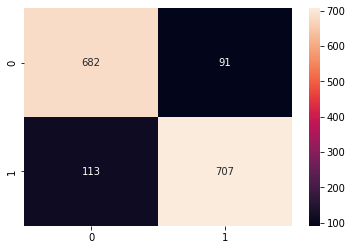

In [ ]:
import seaborn as sns

matrix=confusion_matrix(binary_test.label,preds)
sns.heatmap(matrix, annot=True, fmt="d")
# Visualizing the confusion matrix using Seaborn ----> https://seaborn.pydata.org/generated/seaborn.heatmap.html

### Multi

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for multiclass classification.

nb_grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring="f1_macro")
nb_grid_search.fit(multi_train.text , multi_train.label)


# Report the standart deviation of split scores for each hyperparameter group.

print("STD of hyperparameter combinations",nb_grid_search.cv_results_["std_test_score"])
print("Mean of hyperparameter combinations",nb_grid_search.cv_results_["mean_test_score"])
s0=nb_grid_search.cv_results_["split0_test_score"]
s1=nb_grid_search.cv_results_["split1_test_score"]
s2=nb_grid_search.cv_results_["split2_test_score"]
s3=nb_grid_search.cv_results_["split3_test_score"]
s4=nb_grid_search.cv_results_["split4_test_score"]

max_combs=[]
min_combs=[]
for i in range(9):
  max_comb=np.max([s0[i],s1[i],s2[i],s3[i],s4[i]])
  max_combs.append(max_comb)
  min_comb= np.min([s0[i],s1[i],s2[i],s3[i],s4[i]])
  min_combs.append(min_comb) 

print("Maximum of hyperparameter combinations",max_combs)
print("Minimum of hyperparameter combinations",min_combs)


# Show the best parameter set for given dataset and hyperparameter space.

print("Best parameters",nb_grid_search.best_params_)

# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your pipeline object with the best parameter set.


best_pipe = Pipeline([
     ('vectorizer', TfidfVectorizer(ngram_range=(1,2), min_df=100)), 
     ('dense_transform', DenseTransformer()), 
     ('nb', GaussianNB())
])



# Fit your pipeline on training set.
best_pipe.fit(multi_train.text , multi_train.label)


# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.

preds=best_pipe.predict(multi_test.text)
f1=f1_score(preds,multi_test.label, average='macro')
acc=accuracy_score(preds,multi_test.label)
print("F1 Score---",f1)
print("Accuracy Score---",acc)




STD of hyperparameter combinations [0.0068399  0.00730962 0.00817519 0.00935393 0.00937459 0.00937459
 0.00239006 0.00239006 0.00239006]
Mean of hyperparameter combinations [0.44359808 0.45514883 0.45495473 0.45184773 0.45228208 0.45228208
 0.41969504 0.41969504 0.41969504]
Maximum of hyperparameter combinations [0.4509160782304075, 0.4639170812005009, 0.46449890111192527, 0.46272732461957206, 0.46165368831761777, 0.46165368831761777, 0.4216640232821655, 0.4216640232821655, 0.4216640232821655]
Minimum of hyperparameter combinations [0.43059757151108335, 0.444992516959229, 0.4436251671275933, 0.43527778356316266, 0.4357486133437657, 0.4357486133437657, 0.41524304526381384, 0.41524304526381384, 0.41524304526381384]
Best parameters {'vectorizer__min_df': 100, 'vectorizer__ngram_range': (1, 2)}
F1 Score--- 0.4772514205660536
Accuracy Score--- 0.493
CPU times: user 2min 9s, sys: 2.53 s, total: 2min 12s
Wall time: 2min 12s


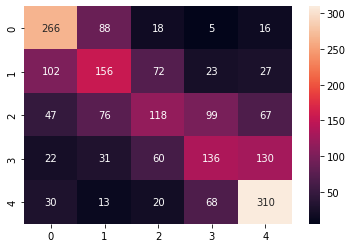

In [ ]:
import seaborn as sns

matrix=confusion_matrix(multi_test.label,preds)
sns.heatmap(matrix, annot=True, fmt="d")
# Visualizing the confusion matrix using Seaborn ----> https://seaborn.pydata.org/generated/seaborn.heatmap.html

### Logistic Regression

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) Word weightning 2) Logistic Regression classifier.
from sklearn.linear_model import LogisticRegression

lr_pipe = Pipeline([
     ('weight', TfidfVectorizer()), 
     ('dense_transform', DenseTransformer()), 
     ('lr', LogisticRegression(random_state=22,solver='saga', penalty='elasticnet')) ###penalty elasticnet is needed to use l1 ratio parameter and saga is needed for elasticnet
])



#Set the hyperparameter space that will be scanned.
from sklearn.model_selection import GridSearchCV
lr_params = {'weight__ngram_range':[(1,1),(1,2),(1,3)], 'weight__min_df':[100, 500,1000] ,'lr__l1_ratio':[0.0,0.5,1.0]}


#### Binary

In [ ]:
#%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.

lr_grid_search = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5, scoring="f1_macro")
lr_grid_search.fit(binary_train.text , binary_train.label)

        
# Report the standart deviation of split scores for each hyperparameter group.


print("STD of hyperparameter combinations",lr_grid_search.cv_results_["std_test_score"])
print("Mean of hyperparameter combinations",lr_grid_search.cv_results_["mean_test_score"])
s0=lr_grid_search.cv_results_["split0_test_score"]
s1=lr_grid_search.cv_results_["split1_test_score"]
s2=lr_grid_search.cv_results_["split2_test_score"]
s3=lr_grid_search.cv_results_["split3_test_score"]
s4=lr_grid_search.cv_results_["split4_test_score"]

max_combs=[]
min_combs=[]
for i in range(27):
  max_comb=np.max([s0[i],s1[i],s2[i],s3[i],s4[i]])
  max_combs.append(max_comb)
  min_comb= np.min([s0[i],s1[i],s2[i],s3[i],s4[i]])
  min_combs.append(min_comb) 

print("Maximum of hyperparameter combinations",max_combs)
print("Minimum of hyperparameter combinations",min_combs)


# Show the best parameter set for given dataset and hyperparameter space.

print("Best parameters",lr_grid_search.best_params_)



# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
#Create your pipeline object with the best parameter set.
best_pipe = Pipeline([
     ('weight', TfidfVectorizer(ngram_range=(1,2), min_df=100)), 
     ('dense_transform', DenseTransformer()), 
     ('lr', LogisticRegression(random_state=(22) ,solver='saga', penalty='elasticnet',l1_ratio=0.5))
])



#Fit your pipeline on training set.
best_pipe.fit(binary_train.text , binary_train.label)


# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.


preds=best_pipe.predict(binary_test.text)
f1=f1_score(preds,binary_test.label, average='binary') ###binary or macro ???
acc=accuracy_score(preds,binary_test.label)
print("F1 Score---",f1)
print("Accuracy Score---",acc)



STD of hyperparameter combinations [0.00296623 0.00397579 0.00397579 0.00472575 0.00451054 0.00451054
 0.00473061 0.00473061 0.00473061 0.00266404 0.00286763 0.00283731
 0.00409892 0.00366651 0.00366651 0.00422603 0.00422603 0.00422603
 0.00505808 0.00473197 0.00473197 0.00431744 0.00423308 0.00423308
 0.00435021 0.00435021 0.00435021]
Mean of hyperparameter combinations [0.90531481 0.9058698  0.9058698  0.85347954 0.85376016 0.85376016
 0.79856394 0.79856394 0.79856394 0.9065656  0.90815942 0.90802064
 0.85473732 0.85438776 0.85438776 0.79917605 0.79917605 0.79917605
 0.90517682 0.90594015 0.90594015 0.8541829  0.85334793 0.85334793
 0.7985484  0.7985484  0.7985484 ]
Maximum of hyperparameter combinations [0.9087111528457442, 0.9121831004157156, 0.9121831004157156, 0.8594319543644307, 0.8590831926684702, 0.8590831926684702, 0.8066192468871356, 0.8066192468871356, 0.8066192468871356, 0.9111395557748878, 0.9132240625186745, 0.9128768013193098, 0.8597773641331576, 0.8587343886297089, 0.8

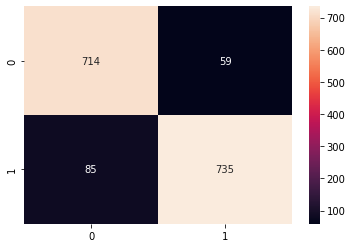

In [ ]:
import seaborn as sns

matrix=confusion_matrix(binary_test.label,preds)
sns.heatmap(matrix, annot=True, fmt="d")
# Visualizing the confusion matrix using Seaborn ----> https://seaborn.pydata.org/generated/seaborn.heatmap.html

#### Multiclass

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for multiclass classification.

lr_grid_search = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5, scoring="f1_macro")
lr_grid_search.fit(multi_train.text , multi_train.label)

        
# Report the standart deviation of split scores for each hyperparameter group.

print("STD of hyperparameter combinations",lr_grid_search.cv_results_["std_test_score"])
print("Mean of hyperparameter combinations",lr_grid_search.cv_results_["mean_test_score"])
s0=lr_grid_search.cv_results_["split0_test_score"]
s1=lr_grid_search.cv_results_["split1_test_score"]
s2=lr_grid_search.cv_results_["split2_test_score"]
s3=lr_grid_search.cv_results_["split3_test_score"]
s4=lr_grid_search.cv_results_["split4_test_score"]

max_combs=[]
min_combs=[]
for i in range(27): ### 3x3x3
  max_comb=np.max([s0[i],s1[i],s2[i],s3[i],s4[i]])
  max_combs.append(max_comb)
  min_comb= np.min([s0[i],s1[i],s2[i],s3[i],s4[i]])
  min_combs.append(min_comb) 

print("Maximum of hyperparameter combinations",max_combs)
print("Minimum of hyperparameter combinations",min_combs)


# Show the best parameter set for given dataset and hyperparameter space.


print("Best parameters",lr_grid_search.best_params_)


# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your pipeline object with the best parameter set.
best_pipe = Pipeline([
     ('weight', TfidfVectorizer(ngram_range=(1,3), min_df=100)), 
     ('dense_transform', DenseTransformer()), 
     ('lr', LogisticRegression(random_state=(22) ,solver='saga', penalty='elasticnet' ,l1_ratio=1.0))
])



# Fit your pipeline on training set.

best_pipe.fit(multi_train.text , multi_train.label)

# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.


preds=best_pipe.predict(multi_test.text)
f1=f1_score(preds,multi_test.label, average='macro') ###binary or macro ???
acc=accuracy_score(preds,multi_test.label)
print("F1 Score---",f1)
print("Accuracy Score---",acc)



STD of hyperparameter combinations [0.00683494 0.00507844 0.00548526 0.01122091 0.01050395 0.01050395
 0.00647229 0.00647229 0.00647229 0.00783204 0.00594587 0.00606887
 0.01122433 0.01122731 0.01122731 0.00629715 0.00629715 0.00629715
 0.00727071 0.00862901 0.00859543 0.01179434 0.01192888 0.01192888
 0.00615056 0.00615056 0.00615056]
Mean of hyperparameter combinations [0.53230304 0.5345478  0.53514486 0.50588763 0.50521023 0.50521023
 0.46189015 0.46189015 0.46189015 0.53239764 0.53788798 0.53787444
 0.50745658 0.50728264 0.50728264 0.46274419 0.46274419 0.46274419
 0.53551595 0.53778099 0.5382825  0.5083085  0.50870402 0.50870402
 0.46190339 0.46190339 0.46190339]
Maximum of hyperparameter combinations [0.5375903794033613, 0.5412376257080042, 0.5421188898349076, 0.5172081075605625, 0.5155694138222282, 0.5155694138222282, 0.47013149704024204, 0.47013149704024204, 0.47013149704024204, 0.5401957457701896, 0.5416643950336322, 0.54179385908984, 0.5174734796258981, 0.5173000651772156, 0.

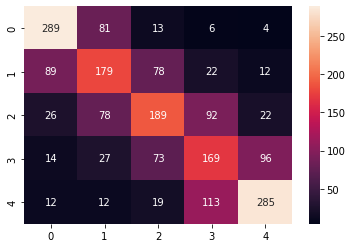

In [ ]:
import seaborn as sns

matrix=confusion_matrix(multi_test.label,preds)
sns.heatmap(matrix, annot=True, fmt="d")
# Visualizing the confusion matrix using Seaborn ----> https://seaborn.pydata.org/generated/seaborn.heatmap.html

## Neural Models

### Convolutional Neural Network (CNN)

In [24]:
import pandas as pd
import numpy as np
import nltk,re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy import array,asarray,zeros

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import Dense,Flatten,Embedding,Input,Dropout
from keras.callbacks import ModelCheckpoint

from gensim.models import Word2Vec
import gensim.downloader as api

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#train

# **BINARY DATA - NEURAL NETWORKS**

In [ ]:
train_temp= binary_train.copy()
test_temp=binary_test.copy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split( train_temp.text, train_temp.label, test_size=0.1, random_state=22)

In [ ]:
print(X_train.shape) 
print(y_train.shape) 
print(X_val.shape) 
print(y_val.shape) 

(12966,)
(12966,)
(1441,)
(1441,)


In [ ]:
from nltk import word_tokenize
#tokenize sentences to create word embedding
def preprocess2(text: str):
    text=word_tokenize(text)
    return text

X_train=X_train.apply(preprocess2)
X_val=X_val.apply(preprocess2)
test_temp.text=test_temp.text.apply(preprocess2)

In [ ]:
# Create your own word embeddings from scratch and load a pretrained word embeddings
import gensim.downloader as api

model_gensim = Word2Vec(sentences=X_train,min_count=1,size=60) 
#model.save("word2vec.model")

glove_vectors = api.load('glove-twitter-50')


#all pre-trained model options below
'''
['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']
'''

# You can check https://radimrehurek.com/gensim/models/word2vec.html for training a word embeddings from scratch


# You can check https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html and https://github.com/RaRe-Technologies/gensim-data for loading pretrained word embeddings. 



[==================================================] 100.0% 199.5/199.5MB downloaded


"\n['fasttext-wiki-news-subwords-300',\n 'conceptnet-numberbatch-17-06-300',\n 'word2vec-ruscorpora-300',\n 'word2vec-google-news-300',\n 'glove-wiki-gigaword-50',\n 'glove-wiki-gigaword-100',\n 'glove-wiki-gigaword-200',\n 'glove-wiki-gigaword-300',\n 'glove-twitter-25',\n 'glove-twitter-50',\n 'glove-twitter-100',\n 'glove-twitter-200',\n '__testing_word2vec-matrix-synopsis']\n"

In [ ]:
print(model_gensim.most_similar('second'))
print(glove_vectors.most_similar('second'))

[('third', 0.8666102290153503), ('first', 0.856019914150238), ('last', 0.833577573299408), ('twice', 0.8335473537445068), ('three', 0.8132480382919312), ('2nd', 0.8128906488418579), ('multipl', 0.8074623346328735), ('coupl', 0.8004127740859985), ('six', 0.7973673343658447), ('husbeast', 0.7944599390029907)]
[('first', 0.9413641691207886), ('third', 0.9368473291397095), ('another', 0.9118744730949402), ('last', 0.8993719816207886), ('every', 0.8912979960441589), ('end', 0.8854801654815674), ('next', 0.8759546279907227), ('year', 0.8659480214118958), ('fourth', 0.8654847145080566), ('minute', 0.8602057099342346)]


In [ ]:
# Prepare your dataset for CNN classifier
my_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=100000000000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,)


my_tokenizer.fit_on_texts(X_train)
tensor_train = my_tokenizer.texts_to_sequences(X_train) 


tensor_val = my_tokenizer.texts_to_sequences(X_val) 


tensor_test = my_tokenizer.texts_to_sequences(test_temp.text) 

# SOURCES :
#https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt  

In [ ]:
len(my_tokenizer.word_index)

19247

In [ ]:

####check average + 10 ? "max" may create problems due to outliers better go with avg
avg_train=0
for i in X_train:
  length=len(i)
  avg_train +=length

avg_train=avg_train/len(X_train)



avg_val=0
for j in X_val:
  length=len(j)
  avg_val +=length

avg_val=avg_val/len(X_val)
print(avg_train, avg_val)

#max_pad=int(max(avg_val,avg_train) + 5)
max_pad=60


59.14885084066019 56.867453157529496


In [ ]:
#we need padding for making data equal simply add 0 to missing indexes 

tensor_train = pad_sequences(tensor_train, padding='post', maxlen=max_pad)
tensor_val = pad_sequences(tensor_val, padding='post', maxlen=max_pad)
tensor_test = pad_sequences(tensor_test, padding='post', maxlen=max_pad)

In [ ]:

##SOURCES I used for word embedding and cnn layers:
## https://ml2021.medium.com/multi-class-text-classification-using-cnn-and-word2vec-b17daff45260
## https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/
## https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
## https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9
## https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html 


In [ ]:
 
# Create Embedding Matrices and Layers
########row sayımız unique words sayısı + 1 unknown word 
vocab_size=len(my_tokenizer.word_index)+1

pretrained=False

def create_embedding_matrix(pretrained, my_tokenizer ):
  if pretrained: #####PRE-TRAINED WORD EMBEDDING MATRIX
    pretrained=True
    embedding_matrix = zeros((vocab_size, 50))
    for word, index in my_tokenizer.word_index.items():
      try:
        embedding_vector = glove_vectors[word]
        #print(embedding_vector)
        embedding_matrix[index] = embedding_vector
        #print("okpre")
      except:
        continue
  else: #####TRAINED FROM SCRATCH WORD EMBEDDING MATRIX
    pretrained=False
    embedding_matrix = zeros((vocab_size, max_pad))
    for word, index in my_tokenizer.word_index.items():
      try:
        embedding_vector = model_gensim[word]
        #print(embedding_vector)
        embedding_matrix[index] = embedding_vector
        #print("ok")
      except:
        continue
  return embedding_matrix



In [ ]:
#if want to use pre-trained embeddings make it True, if want to use trained from scratch embeddings make it False
pre_trained_embedding_matrix=create_embedding_matrix(True,my_tokenizer)
trained_embedding_matrix=create_embedding_matrix(False,my_tokenizer)

In [ ]:
pre_trained_embedding_matrix.shape

(19248, 50)

In [ ]:
trained_embedding_matrix.shape

(19248, 60)

# RANDOM EMBEDDING -BINARY

In [ ]:
##############################################   BINARYYYYYYYYYY WITH  RANDOM - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################       
# Create Embedding Matrices and Layers

# Building the CNN Model
model_b1 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b1.add(Embedding(vocab_size, 60, input_length=max_pad))
model_b1.add(Conv1D(128, 5, padding='same', activation='relu'))
model_b1.add(MaxPooling1D())
#model_b1.add(Conv1D(64,5, activation='relu'))
#model_b1.add(MaxPooling1D())
model_b1.add(Conv1D(32,5, activation='relu'))
model_b1.add(MaxPooling1D())
model_b1.add(Flatten())
model_b1.add(Dense(20, activation='relu'))
model_b1.add(Dense(1, activation='sigmoid'))
# compile the model
model_b1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b1.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 60, 60)            1154880   
                                                                 
 conv1d_43 (Conv1D)          (None, 60, 128)           38528     
                                                                 
 max_pooling1d_43 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_44 (Conv1D)          (None, 26, 32)            20512     
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 13, 32)           0         
 g1D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 416)             

Epoch 1/5
406/406 [==============================] - 17s 38ms/step - loss: 0.3588 - accuracy: 0.8241 - val_loss: 0.2331 - val_accuracy: 0.9035
Epoch 2/5
406/406 [==============================] - 13s 32ms/step - loss: 0.1430 - accuracy: 0.9474 - val_loss: 0.2641 - val_accuracy: 0.9042
Epoch 3/5
406/406 [==============================] - 13s 32ms/step - loss: 0.0684 - accuracy: 0.9782 - val_loss: 0.3224 - val_accuracy: 0.8890
Epoch 4/5
406/406 [==============================] - 13s 33ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.4679 - val_accuracy: 0.8931
Epoch 5/5
50/50 [==============================] - 0s 6ms/step - loss: 0.5386 - accuracy: 0.8788
Accuracy for binary test data 0.8788449764251709
50/50 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       773
           1       0.91      0.85      0.88       820

    accuracy                           0.88      1593
   macro av

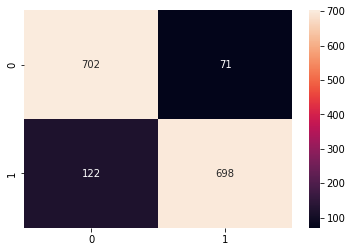

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b1.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b1.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b1.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

In [ ]:
##############################################   BINARYYYYYYYYYY WITH  RANDOM - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################       
# Create Embedding Matrices and Layers

# Building the CNN Model
model_b7 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b7.add(Embedding(vocab_size, 60, input_length=max_pad))
model_b7.add(Conv1D(256, 5, padding='same', activation='relu'))
model_b7.add(MaxPooling1D())
model_b7.add(Conv1D(128, 5, padding='same', activation='relu'))
model_b7.add(MaxPooling1D())
model_b7.add(Conv1D(64,5, activation='relu'))
#model_b7.add(MaxPooling1D())
model_b7.add(Conv1D(32,5, activation='relu'))
#model_b7.add(MaxPooling1D())
model_b7.add(Flatten())
model_b7.add(Dense(20, activation='relu'))
model_b7.add(Dense(1, activation='sigmoid'))
# compile the model
model_b7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b7.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 60)            1154880   
                                                                 
 conv1d_8 (Conv1D)           (None, 60, 256)           77056     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 30, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 128)           163968    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 11, 64)           

Epoch 1/5
406/406 [==============================] - 35s 80ms/step - loss: 0.3566 - accuracy: 0.8339 - val_loss: 0.2440 - val_accuracy: 0.9035
Epoch 2/5
406/406 [==============================] - 30s 74ms/step - loss: 0.1527 - accuracy: 0.9435 - val_loss: 0.2460 - val_accuracy: 0.9028
Epoch 3/5
406/406 [==============================] - 30s 73ms/step - loss: 0.0745 - accuracy: 0.9757 - val_loss: 0.3690 - val_accuracy: 0.8924
Epoch 4/5
406/406 [==============================] - 31s 77ms/step - loss: 0.0430 - accuracy: 0.9850 - val_loss: 0.3924 - val_accuracy: 0.8966
Epoch 5/5
50/50 [==============================] - 1s 15ms/step - loss: 0.6615 - accuracy: 0.8776
Accuracy for binary test data 0.8775894641876221
50/50 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       773
           1       0.89      0.87      0.88       820

    accuracy                           0.88      1593
   macro 

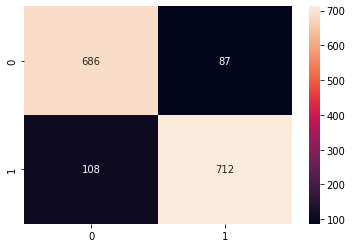

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b7.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b7.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b7.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

In [ ]:
##############################################   BINARYYYYYYYYYY WITH  RANDOM - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################       
# Create Embedding Matrices and Layers

# Building the CNN Model
model_b8 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b8.add(Embedding(vocab_size, 60, input_length=max_pad))
model_b8.add(Conv1D(256, 9, padding='same', activation='relu'))
model_b8.add(MaxPooling1D())
model_b8.add(Conv1D(128, 9, padding='same', activation='relu'))
model_b8.add(MaxPooling1D())
model_b8.add(Conv1D(64,9, activation='relu'))
#model_b7.add(MaxPooling1D())
model_b8.add(Conv1D(32,5, activation='relu'))
#model_b7.add(MaxPooling1D())
model_b8.add(Flatten())
model_b8.add(Dense(250, activation='relu'))
model_b8.add(Dense(200, activation='relu'))
model_b8.add(Dense(1, activation='sigmoid'))
# compile the model
model_b8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b8.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 60)            1154880   
                                                                 
 conv1d_12 (Conv1D)          (None, 60, 256)           138496    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 30, 256)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 30, 128)           295040    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 15, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 7, 64)            

Epoch 1/5
406/406 [==============================] - 50s 120ms/step - loss: 0.3398 - accuracy: 0.8474 - val_loss: 0.2428 - val_accuracy: 0.9008
Epoch 2/5
406/406 [==============================] - 50s 122ms/step - loss: 0.1501 - accuracy: 0.9447 - val_loss: 0.3392 - val_accuracy: 0.8987
Epoch 3/5
406/406 [==============================] - 48s 119ms/step - loss: 0.0794 - accuracy: 0.9732 - val_loss: 0.4836 - val_accuracy: 0.8723
Epoch 4/5
406/406 [==============================] - 50s 122ms/step - loss: 0.0469 - accuracy: 0.9842 - val_loss: 0.4602 - val_accuracy: 0.8820
Epoch 5/5
50/50 [==============================] - 1s 24ms/step - loss: 0.6745 - accuracy: 0.8814
Accuracy for binary test data 0.8813559412956238
50/50 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       773
           1       0.89      0.88      0.88       820

    accuracy                           0.88      1593
   ma

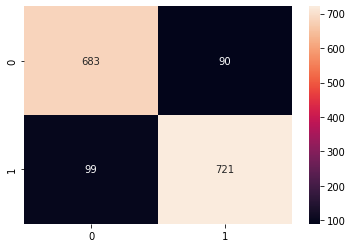

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b8.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b8.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b8.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

# PRE-TRAINED EMBEDDING -BINARY

In [ ]:
 ##############################################   BINARYYYYYYYYYY WITH  PRETRAINEDDD WORD - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################  

# Create Embedding Matrices and Layers

# Building the CNN Model
model_b2 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b2.add(Embedding(vocab_size, 50 ,input_length=max_pad,weights=[pre_trained_embedding_matrix],trainable=True))
model_b2.add(Conv1D(128, 5, padding='same', activation='relu'))
model_b2.add(MaxPooling1D())
model_b2.add(Conv1D(32,5, activation='relu'))
model_b2.add(MaxPooling1D())
model_b2.add(Flatten())
model_b2.add(Dense(20, activation='relu'))
model_b2.add(Dense(1, activation='sigmoid'))
# compile the model
model_b2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b2.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 60, 50)            962400    
                                                                 
 conv1d_39 (Conv1D)          (None, 60, 128)           32128     
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_40 (Conv1D)          (None, 26, 32)            20512     
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 13, 32)           0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 416)             

Epoch 1/5
406/406 [==============================] - 12s 29ms/step - loss: 0.4566 - accuracy: 0.7735 - val_loss: 0.2843 - val_accuracy: 0.8876
Epoch 2/5
406/406 [==============================] - 12s 28ms/step - loss: 0.2353 - accuracy: 0.9101 - val_loss: 0.2369 - val_accuracy: 0.9042
Epoch 3/5
406/406 [==============================] - 11s 28ms/step - loss: 0.1423 - accuracy: 0.9483 - val_loss: 0.2637 - val_accuracy: 0.9042
Epoch 4/5
406/406 [==============================] - 11s 28ms/step - loss: 0.0753 - accuracy: 0.9749 - val_loss: 0.2869 - val_accuracy: 0.9035
Epoch 5/5
50/50 [==============================] - 0s 6ms/step - loss: 0.4854 - accuracy: 0.8870
Accuracy for binary test data 0.887005627155304
50/50 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       773
           1       0.91      0.87      0.89       820

    accuracy                           0.89      1593
   macro avg

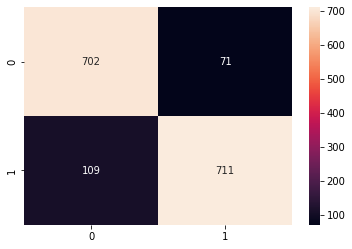

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b2.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b2.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b2.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

In [ ]:
 ##############################################   BINARYYYYYYYYYY WITH  PRETRAINEDDD WORD - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################  

# Create Embedding Matrices and Layers

# Building the CNN Model
model_b9 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b9.add(Embedding(vocab_size, 50 ,input_length=max_pad,weights=[pre_trained_embedding_matrix],trainable=True))
model_b9.add(Conv1D(256, 3, padding='same', activation='relu'))
model_b9.add(Conv1D(128, 3, padding='same', activation='relu'))
model_b9.add(MaxPooling1D())
model_b9.add(Conv1D(32,5, activation='relu'))
model_b9.add(MaxPooling1D())
model_b9.add(Flatten())
model_b9.add(Dense(20, activation='relu'))
model_b9.add(Dense(1, activation='sigmoid'))
# compile the model
model_b9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b9.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 50)            962400    
                                                                 
 conv1d_16 (Conv1D)          (None, 60, 256)           38656     
                                                                 
 conv1d_17 (Conv1D)          (None, 60, 128)           98432     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 26, 32)            20512     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 13, 32)           0         
 g1D)                                                 

Epoch 1/5
406/406 [==============================] - 28s 66ms/step - loss: 0.4267 - accuracy: 0.7955 - val_loss: 0.2567 - val_accuracy: 0.8945
Epoch 2/5
406/406 [==============================] - 27s 65ms/step - loss: 0.2280 - accuracy: 0.9097 - val_loss: 0.2297 - val_accuracy: 0.9188
Epoch 3/5
406/406 [==============================] - 27s 67ms/step - loss: 0.1510 - accuracy: 0.9445 - val_loss: 0.2370 - val_accuracy: 0.9146
Epoch 4/5
406/406 [==============================] - 26s 65ms/step - loss: 0.0934 - accuracy: 0.9673 - val_loss: 0.2798 - val_accuracy: 0.9028
Epoch 5/5
50/50 [==============================] - 1s 13ms/step - loss: 0.3899 - accuracy: 0.8908
Accuracy for binary test data 0.8907721042633057
50/50 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       773
           1       0.89      0.90      0.89       820

    accuracy                           0.89      1593
   macro 

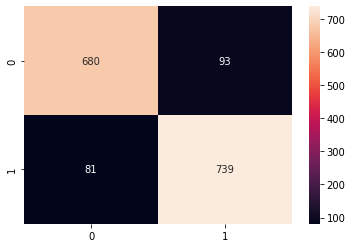

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b9.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b9.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b9.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

# TRAINED EMBEDDING -BINARY

In [ ]:
##############################################   BINARYYYYYYYYYY WITH  TRAINEDDD FROM SCRATCHH WORD - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################  

# Create Embedding Matrices and Layers

# Building the CNN Model
model_b3 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b3.add(Embedding(vocab_size, 60 ,input_length=max_pad,weights=[trained_embedding_matrix]))
model_b3.add(Conv1D(128, 5, padding='same', activation='relu'))
model_b3.add(MaxPooling1D())
model_b3.add(Conv1D(32,5, activation='relu'))
model_b3.add(MaxPooling1D())
model_b3.add(Flatten())
model_b3.add(Dense(20, activation='relu'))
model_b3.add(Dense(1, activation='sigmoid'))
# compile the model
model_b3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b3.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 60, 60)            1154880   
                                                                 
 conv1d_41 (Conv1D)          (None, 60, 128)           38528     
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 30, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_42 (Conv1D)          (None, 26, 32)            20512     
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 13, 32)           0         
 g1D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 416)             

Epoch 1/5
406/406 [==============================] - 16s 38ms/step - loss: 0.3934 - accuracy: 0.8155 - val_loss: 0.3350 - val_accuracy: 0.8577
Epoch 2/5
406/406 [==============================] - 13s 31ms/step - loss: 0.2485 - accuracy: 0.8994 - val_loss: 0.2431 - val_accuracy: 0.9084
Epoch 3/5
406/406 [==============================] - 13s 32ms/step - loss: 0.1660 - accuracy: 0.9359 - val_loss: 0.2274 - val_accuracy: 0.9098
Epoch 4/5
406/406 [==============================] - 13s 32ms/step - loss: 0.1023 - accuracy: 0.9632 - val_loss: 0.2638 - val_accuracy: 0.9098
Epoch 5/5
50/50 [==============================] - 0s 7ms/step - loss: 0.3173 - accuracy: 0.9008
Accuracy for binary test data 0.9008160829544067
50/50 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       773
           1       0.90      0.91      0.90       820

    accuracy                           0.90      1593
   macro av

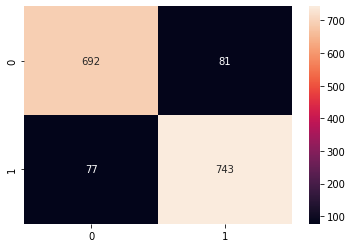

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b3.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b3.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b3.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

In [ ]:
##############################################   BINARYYYYYYYYYY WITH  TRAINEDDD FROM SCRATCHH WORD - EMBEDDING MATRIX   ##############################################
##############################################   BINARYYYYYYYYYY    ##############################################  

# Create Embedding Matrices and Layers

# Building the CNN Model
model_b10 = Sequential()      # initilaizing the Sequential nature for CNN model
model_b10.add(Embedding(vocab_size, 60 ,input_length=max_pad,weights=[trained_embedding_matrix]))
model_b10.add(Conv1D(256, 7, padding='same', activation='relu'))
model_b10.add(MaxPooling1D())
model_b10.add(Conv1D(128, 7, padding='same', activation='relu'))
model_b10.add(MaxPooling1D())
model_b10.add(Conv1D(64,7, activation='relu'))
model_b10.add(Conv1D(32,7, activation='relu'))
model_b10.add(Flatten())
model_b10.add(Dense(400, activation='relu'))
model_b10.add(Dense(250, activation='relu'))
model_b10.add(Dense(20, activation='relu'))
model_b10.add(Dense(1, activation='sigmoid'))
# compile the model
model_b10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_b10.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 60, 60)            1154880   
                                                                 
 conv1d_31 (Conv1D)          (None, 60, 256)           107776    
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 30, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_32 (Conv1D)          (None, 30, 128)           229504    
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 15, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 9, 64)            

Epoch 1/8
406/406 [==============================] - 45s 106ms/step - loss: 0.3857 - accuracy: 0.8314 - val_loss: 0.2806 - val_accuracy: 0.8883
Epoch 2/8
406/406 [==============================] - 43s 105ms/step - loss: 0.2514 - accuracy: 0.9003 - val_loss: 0.2778 - val_accuracy: 0.8855
Epoch 3/8
406/406 [==============================] - 42s 104ms/step - loss: 0.1778 - accuracy: 0.9352 - val_loss: 0.3308 - val_accuracy: 0.8619
Epoch 4/8
406/406 [==============================] - 42s 103ms/step - loss: 0.1134 - accuracy: 0.9602 - val_loss: 0.2674 - val_accuracy: 0.9126
Epoch 5/8
406/406 [==============================] - 42s 103ms/step - loss: 0.0726 - accuracy: 0.9762 - val_loss: 0.3043 - val_accuracy: 0.9153
Epoch 6/8
406/406 [==============================] - 42s 105ms/step - loss: 0.0437 - accuracy: 0.9840 - val_loss: 0.4585 - val_accuracy: 0.9049
Epoch 7/8
406/406 [==============================] - 42s 103ms/step - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.5348 - val_accuracy:

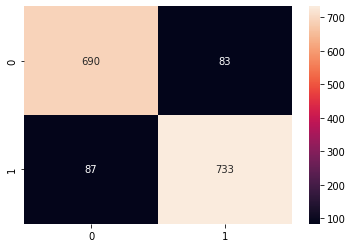

In [ ]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_b10.fit(tensor_train, y_train, epochs=8, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_b10.evaluate(tensor_test, binary_test.label, verbose=1)
print("Accuracy for binary test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_b10.predict(tensor_test, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1) #argmax makes predictions 0 since there is one value so I set a threshold
y_pred_bool=y_pred.copy()
y_pred_bool[y_pred_bool<0.5]=0
y_pred_bool[y_pred_bool>0.5]=1

print(classification_report(binary_test.label, y_pred_bool))

cf_matrix=confusion_matrix(binary_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

# **MULTI-CLASS DATA NEURAL NETWORK**

In [19]:

train_temp= multi_train.copy()
test_temp=multi_test.copy()


In [20]:
# Create a validation set from train set
# Please use random_state of 22 and test_size of 0.1
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split( train_temp.text, train_temp.label, test_size=0.1, random_state=22)


In [21]:
print(X_train.shape) 
print(y_train.shape) 
print(X_val.shape) 
print(y_val.shape) 

(16200,)
(16200,)
(1800,)
(1800,)


In [22]:
from nltk import word_tokenize
#tokenize sentences to create word embedding
def preprocess2(text: str):
    text=word_tokenize(text)
    return text

X_train=X_train.apply(preprocess2)
X_val=X_val.apply(preprocess2)
test_temp.text=test_temp.text.apply(preprocess2)

In [25]:
# Create your own word embeddings from scratch and load a pretrained word embeddings
import gensim.downloader as api

model_gensim = Word2Vec(sentences=X_train,min_count=1,size=60) 
#model.save("word2vec.model")

glove_vectors = api.load('glove-twitter-50')


#all pre-trained model options below
'''
['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']
'''

# You can check https://radimrehurek.com/gensim/models/word2vec.html for training a word embeddings from scratch


# You can check https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html and https://github.com/RaRe-Technologies/gensim-data for loading pretrained word embeddings. 



[==================================================] 100.0% 199.5/199.5MB downloaded


"\n['fasttext-wiki-news-subwords-300',\n 'conceptnet-numberbatch-17-06-300',\n 'word2vec-ruscorpora-300',\n 'word2vec-google-news-300',\n 'glove-wiki-gigaword-50',\n 'glove-wiki-gigaword-100',\n 'glove-wiki-gigaword-200',\n 'glove-wiki-gigaword-300',\n 'glove-twitter-25',\n 'glove-twitter-50',\n 'glove-twitter-100',\n 'glove-twitter-200',\n '__testing_word2vec-matrix-synopsis']\n"

In [26]:
print(model_gensim.most_similar('second'))
print(glove_vectors.most_similar('second'))

[('third', 0.8647754192352295), ('first', 0.8287521600723267), ('1st', 0.7931504249572754), ('multipl', 0.7797762155532837), ('last', 0.7792950868606567), ('7yo', 0.7709883451461792), ('homosexu', 0.7406263947486877), ('twice', 0.7318850159645081), ('phoni', 0.7284115552902222), ('2nd', 0.7226787805557251)]
[('first', 0.9413641691207886), ('third', 0.9368473291397095), ('another', 0.9118744730949402), ('last', 0.8993719816207886), ('every', 0.8912979960441589), ('end', 0.8854801654815674), ('next', 0.8759546279907227), ('year', 0.8659480214118958), ('fourth', 0.8654847145080566), ('minute', 0.8602057099342346)]


In [27]:
len(model_gensim['second'])

60

In [28]:
# Prepare your dataset for CNN classifier
my_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=100000000000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,)


my_tokenizer.fit_on_texts(X_train)
tensor_train = my_tokenizer.texts_to_sequences(X_train) 


tensor_val = my_tokenizer.texts_to_sequences(X_val) 


tensor_test = my_tokenizer.texts_to_sequences(test_temp.text) 

# SOURCES :
#https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt  

In [29]:
print(len(tensor_train)) 
print(len(tensor_val)) 
print(len(tensor_test)) 

16200
1800
2000


In [58]:
#my_tokenizer.word_index.items()

In [31]:
len(my_tokenizer.word_index)

21049

In [32]:

####check average + 10 ? max may create problems due to outliers better with avg
avg_train=0
for i in X_train:
  length=len(i)
  avg_train +=length

avg_train=avg_train/len(X_train)



avg_val=0
for j in X_val:
  length=len(j)
  avg_val +=length

avg_val=avg_val/len(X_val)
print(avg_train, avg_val)

#max_pad=int(max(avg_val,avg_train) + 5)
max_pad=60


59.803765432098764 58.895


In [33]:
#we need padding for making data equal simply add 0 to missing indexes 

tensor_train = pad_sequences(tensor_train, padding='post', maxlen=max_pad)
tensor_val = pad_sequences(tensor_val, padding='post', maxlen=max_pad)
tensor_test = pad_sequences(tensor_test, padding='post', maxlen=max_pad)

In [34]:

##SOURCES I used for word embedding and cnn layers:
## https://ml2021.medium.com/multi-class-text-classification-using-cnn-and-word2vec-b17daff45260
## https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/
## https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
## https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9
## https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html 


In [35]:

 
# Create Embedding Matrices and Layers
########row sayımız unique words sayısı + 1 unknown word 
vocab_size=len(my_tokenizer.word_index)+1

pretrained=False

def create_embedding_matrix(pretrained, my_tokenizer ):
  if pretrained: #####PRE-TRAINED WORD EMBEDDING MATRIX
    pretrained=True
    embedding_matrix = zeros((vocab_size, 50))
    for word, index in my_tokenizer.word_index.items():
      try:
        embedding_vector = glove_vectors[word]
        #print(embedding_vector)
        embedding_matrix[index] = embedding_vector
        #print("okpre")
      except:
        continue
  else: #####TRAINED FROM SCRATCH WORD EMBEDDING MATRIX
    pretrained=False
    embedding_matrix = zeros((vocab_size, max_pad))
    for word, index in my_tokenizer.word_index.items():
      try:
        embedding_vector = model_gensim[word]
        #print(embedding_vector)
        embedding_matrix[index] = embedding_vector
        #print("ok")
      except:
        continue
  return embedding_matrix



In [36]:
pre_trained_embedding_matrix=create_embedding_matrix(True,my_tokenizer)
trained_embedding_matrix=create_embedding_matrix(False,my_tokenizer)

In [37]:
print(pre_trained_embedding_matrix.shape)
print(trained_embedding_matrix.shape)

(21050, 50)
(21050, 60)


# RANDOM EMBEDDING - MULTI

In [38]:
##############################################   MULTICLASSSSSSSSS wITH RANDOM WEIGHTS - EMBEDDINGS   ##############################################       
# 2 conv layers kernel_size=5 dense=20
# Building the CNN Model M1
model_m1 = Sequential()     
model_m1.add(Embedding(vocab_size, max_pad ,input_length=max_pad))
model_m1.add(Conv1D(128, 5, padding='same', activation='relu'))
model_m1.add(MaxPooling1D())
model_m1.add(Conv1D(64, 5, padding='same', activation='relu'))
model_m1.add(MaxPooling1D())
model_m1.add(Flatten())
model_m1.add(Dense(20, activation='relu'))
model_m1.add(Dense(5, activation='softmax'))
# compile the model
model_m1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_m1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 60)            1263000   
                                                                 
 conv1d (Conv1D)             (None, 60, 128)           38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 960)               0

Epoch 1/5
507/507 [==============================] - 20s 38ms/step - loss: 1.3393 - accuracy: 0.3687 - val_loss: 1.1609 - val_accuracy: 0.4817
Epoch 2/5
507/507 [==============================] - 19s 38ms/step - loss: 0.9747 - accuracy: 0.5647 - val_loss: 1.0928 - val_accuracy: 0.5367
Epoch 3/5
507/507 [==============================] - 19s 38ms/step - loss: 0.7666 - accuracy: 0.6762 - val_loss: 1.1706 - val_accuracy: 0.5261
Epoch 4/5
507/507 [==============================] - 19s 38ms/step - loss: 0.5804 - accuracy: 0.7672 - val_loss: 1.4680 - val_accuracy: 0.5028
Epoch 5/5
63/63 [==============================] - 1s 8ms/step - loss: 1.8071 - accuracy: 0.5205
Accuracy for multi test data 0.5205000042915344
63/63 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       393
           1       0.46      0.40      0.43       380
           2       0.42      0.48      0.45       407
           3 

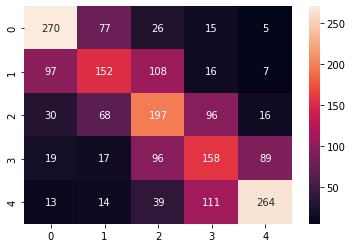

In [39]:
# Train models and Evaluate them for both binary and multi-class
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 

model_m1.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_m1.evaluate(tensor_test, multi_test.label, verbose=1)
print("Accuracy for multi test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_m1.predict(tensor_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(multi_test.label, y_pred_bool))

cf_matrix=confusion_matrix(multi_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")


In [40]:
##############################################   MULTICLASSSSSSSSS WITH  RANDOM - EMBEDDING MATRIX   ##############################################
# Building the CNN Model
#### 2 conv layers kernel_size=5 ,dense =100
model_m3 = Sequential()     
model_m3.add(Embedding(vocab_size, max_pad ,input_length=max_pad))
model_m3.add(Conv1D(128, 5, padding='same', activation='relu'))
model_m3.add(MaxPooling1D())
model_m3.add(Conv1D(64, 5, padding='same', activation='relu'))
model_m3.add(MaxPooling1D())
model_m3.add(Flatten())
model_m3.add(Dense(400, activation='relu'))
#model_m3.add(Dense(20, activation='relu'))
model_m3.add(Dense(5, activation='softmax'))
# compile the model
model_m3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_m3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 60)            1263000   
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           38528     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 64)            41024     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 960)              

Epoch 1/5
507/507 [==============================] - 22s 42ms/step - loss: 1.2695 - accuracy: 0.4083 - val_loss: 1.0654 - val_accuracy: 0.5222
Epoch 2/5
507/507 [==============================] - 21s 41ms/step - loss: 0.9245 - accuracy: 0.5970 - val_loss: 1.0720 - val_accuracy: 0.5406
Epoch 3/5
507/507 [==============================] - 21s 41ms/step - loss: 0.6964 - accuracy: 0.7117 - val_loss: 1.2212 - val_accuracy: 0.5272
Epoch 4/5
507/507 [==============================] - 21s 41ms/step - loss: 0.4927 - accuracy: 0.8019 - val_loss: 1.6200 - val_accuracy: 0.5056
Epoch 5/5
63/63 [==============================] - 1s 8ms/step - loss: 1.9923 - accuracy: 0.5115
Accuracy for multi test data 0.5115000009536743
63/63 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.73      0.52      0.61       393
           1       0.43      0.57      0.49       380
           2       0.43      0.50      0.46       407
           3 

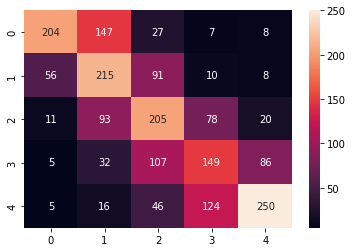

In [41]:
# Train models and Evaluate them for both binary and multi-class
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 

model_m3.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_m3.evaluate(tensor_test, multi_test.label, verbose=1)
print("Accuracy for multi test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_m3.predict(tensor_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(multi_test.label, y_pred_bool))

cf_matrix=confusion_matrix(multi_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")


# PRE-TRAINED EMBEDDING- MULTI

In [42]:
##############################################   MULTICLASSSSSSSSS WITH PRETRAINED- EMBEDDING MATRIX   ##############################################       

# Building the CNN Model
model_m2 = Sequential()
model_m2.add(Embedding(vocab_size, 50 ,input_length=max_pad,weights=[pre_trained_embedding_matrix],trainable=True))
model_m2.add(Conv1D(128, 3, padding='same', activation='relu'))
model_m2.add(MaxPooling1D())
model_m2.add(Conv1D(64, 3, padding='same', activation='relu'))
model_m2.add(MaxPooling1D())
model_m2.add(Flatten())
model_m2.add(Dense(20, activation='relu'))
model_m2.add(Dense(5, activation='softmax'))
# compile the model
model_m2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_m2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 50)            1052500   
                                                                 
 conv1d_4 (Conv1D)           (None, 60, 128)           19328     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 64)            24640     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 960)              

Epoch 1/5
507/507 [==============================] - 15s 29ms/step - loss: 1.3850 - accuracy: 0.3599 - val_loss: 1.2075 - val_accuracy: 0.4483
Epoch 2/5
507/507 [==============================] - 15s 29ms/step - loss: 1.1309 - accuracy: 0.4840 - val_loss: 1.1525 - val_accuracy: 0.4761
Epoch 3/5
507/507 [==============================] - 15s 29ms/step - loss: 0.9908 - accuracy: 0.5581 - val_loss: 1.1248 - val_accuracy: 0.5061
Epoch 4/5
507/507 [==============================] - 14s 28ms/step - loss: 0.8577 - accuracy: 0.6259 - val_loss: 1.1620 - val_accuracy: 0.5111
Epoch 5/5
63/63 [==============================] - 0s 6ms/step - loss: 1.3152 - accuracy: 0.5045
Accuracy for multi test data 0.5044999718666077
63/63 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       393
           1       0.46      0.42      0.44       380
           2       0.39      0.36      0.38       407
           3 

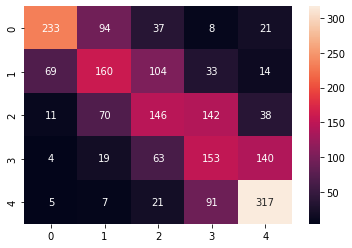

In [43]:
# Train models and Evaluate them for both binary and multi-class
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 

model_m2.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_m2.evaluate(tensor_test, multi_test.label, verbose=1)
print("Accuracy for multi test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_m2.predict(tensor_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(multi_test.label, y_pred_bool))

cf_matrix=confusion_matrix(multi_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")


In [44]:
##############################################   MULTICLASSSSSSSSS WITH PRETRAINED- EMBEDDING MATRIX   ##############################################       

# Building the CNN Model
model_m5 = Sequential()
model_m5.add(Embedding(vocab_size, 50 ,input_length=max_pad,weights=[pre_trained_embedding_matrix],trainable=True))
model_m5.add(Conv1D(128, 9, padding='same', activation='relu'))
model_m5.add(MaxPooling1D())
model_m5.add(Conv1D(64, 9, padding='same', activation='relu'))
model_m5.add(MaxPooling1D())
model_m5.add(Flatten())
model_m5.add(Dense(20, activation='relu'))
model_m5.add(Dense(5, activation='softmax'))
# compile the model
model_m5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_m5.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 50)            1052500   
                                                                 
 conv1d_6 (Conv1D)           (None, 60, 128)           57728     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 30, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 64)            73792     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 960)              

Epoch 1/5
507/507 [==============================] - 23s 45ms/step - loss: 1.4072 - accuracy: 0.3499 - val_loss: 1.2228 - val_accuracy: 0.4339
Epoch 2/5
507/507 [==============================] - 23s 45ms/step - loss: 1.1109 - accuracy: 0.5069 - val_loss: 1.1006 - val_accuracy: 0.5167
Epoch 3/5
507/507 [==============================] - 23s 44ms/step - loss: 0.9364 - accuracy: 0.5886 - val_loss: 1.0914 - val_accuracy: 0.5178
Epoch 4/5
507/507 [==============================] - 23s 44ms/step - loss: 0.7598 - accuracy: 0.6738 - val_loss: 1.2185 - val_accuracy: 0.5172
Epoch 5/5
63/63 [==============================] - 1s 10ms/step - loss: 1.5316 - accuracy: 0.4910
Accuracy for multi test data 0.4909999966621399
63/63 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       393
           1       0.40      0.57      0.47       380
           2       0.40      0.52      0.45       407
           

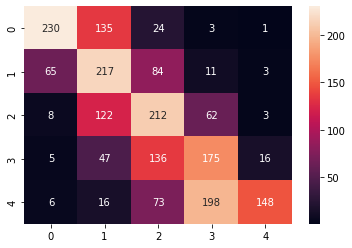

In [45]:
# Train models and Evaluate them for both binary and multi-class
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 

model_m5.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_m5.evaluate(tensor_test, multi_test.label, verbose=1)
print("Accuracy for multi test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_m5.predict(tensor_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(multi_test.label, y_pred_bool))

cf_matrix=confusion_matrix(multi_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")


# TRAINED EMBEDDING - MULTI 

In [46]:
##############################################   MULTICLASSSSSSSSS WITH  NOT-RANDOM - EMBEDDING MATRIX   ##############################################
# Building the CNN Model
#### 3 conv layers kernel_size=3
model_m4 = Sequential()     
model_m4.add(Embedding(vocab_size, max_pad ,input_length=max_pad,weights=[trained_embedding_matrix],trainable=True))
model_m4.add(Conv1D(256, 7, padding='same', activation='relu'))
model_m4.add(MaxPooling1D())
model_m4.add(Conv1D(128, 7, padding='same', activation='relu'))
model_m4.add(MaxPooling1D())
model_m4.add(Conv1D(64, 7, padding='same', activation='relu'))
model_m4.add(MaxPooling1D())
model_m4.add(Flatten())
model_m4.add(Dense(20, activation='relu'))
model_m4.add(Dense(5, activation='softmax'))
# compile the model
model_m4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_m4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 60, 60)            1263000   
                                                                 
 conv1d_8 (Conv1D)           (None, 60, 256)           107776    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 30, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 128)           229504    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 15, 64)           

Epoch 1/5
507/507 [==============================] - 55s 107ms/step - loss: 1.2907 - accuracy: 0.4233 - val_loss: 1.1291 - val_accuracy: 0.4972
Epoch 2/5
507/507 [==============================] - 54s 107ms/step - loss: 1.0716 - accuracy: 0.5281 - val_loss: 1.0745 - val_accuracy: 0.5317
Epoch 3/5
507/507 [==============================] - 54s 106ms/step - loss: 0.9466 - accuracy: 0.5871 - val_loss: 1.0948 - val_accuracy: 0.5289
Epoch 4/5
507/507 [==============================] - 57s 112ms/step - loss: 0.8116 - accuracy: 0.6501 - val_loss: 1.1662 - val_accuracy: 0.5133
Epoch 5/5
63/63 [==============================] - 2s 28ms/step - loss: 1.2597 - accuracy: 0.5385
Accuracy for multi test data 0.5385000109672546
63/63 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       393
           1       0.44      0.43      0.44       380
           2       0.42      0.51      0.46       407
       

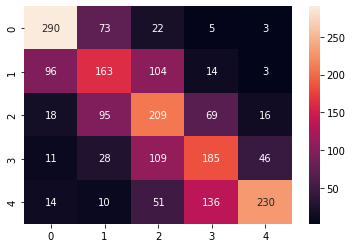

In [47]:
# Train models and Evaluate them for both binary and multi-class
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 

model_m4.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_m4.evaluate(tensor_test, multi_test.label, verbose=1)
print("Accuracy for multi test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_m4.predict(tensor_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(multi_test.label, y_pred_bool))

cf_matrix=confusion_matrix(multi_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")


In [53]:
##############################################   MULTICLASSSSSSSSS WITH  NOT-RANDOM - EMBEDDING MATRIX   ##############################################
# Building the CNN Model
#### 3 conv layers kernel_size=3
model_m4 = Sequential()     
model_m4.add(Embedding(vocab_size, max_pad ,input_length=max_pad,weights=[trained_embedding_matrix],trainable=True))
model_m4.add(Conv1D(64, 3, padding='same', activation='relu'))
model_m4.add(MaxPooling1D())
#model_m4.add(Conv1D(128, 7, padding='same', activation='relu'))
#model_m4.add(MaxPooling1D())
#model_m4.add(Conv1D(64, 7, padding='same', activation='relu'))
#model_m4.add(MaxPooling1D())
model_m4.add(Flatten())
model_m4.add(Dense(20, activation='relu'))
model_m4.add(Dense(5, activation='softmax'))
# compile the model
model_m4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_m4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 60, 60)            1263000   
                                                                 
 conv1d_13 (Conv1D)          (None, 60, 64)            11584     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 30, 64)           0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 1920)              0         
                                                                 
 dense_14 (Dense)            (None, 20)                38420     
                                                                 
 dense_15 (Dense)            (None, 5)                 105       
                                                      

Epoch 1/5
507/507 [==============================] - 25s 47ms/step - loss: 1.3258 - accuracy: 0.3952 - val_loss: 1.1849 - val_accuracy: 0.4817
Epoch 2/5
507/507 [==============================] - 21s 42ms/step - loss: 1.0763 - accuracy: 0.5248 - val_loss: 1.1149 - val_accuracy: 0.5239
Epoch 3/5
507/507 [==============================] - 21s 42ms/step - loss: 0.9403 - accuracy: 0.5893 - val_loss: 1.1006 - val_accuracy: 0.5389
Epoch 4/5
507/507 [==============================] - 18s 36ms/step - loss: 0.8112 - accuracy: 0.6546 - val_loss: 1.1548 - val_accuracy: 0.5228
Epoch 5/5
63/63 [==============================] - 0s 6ms/step - loss: 1.2492 - accuracy: 0.5050
Accuracy for multi test data 0.5049999952316284
63/63 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       393
           1       0.42      0.53      0.47       380
           2       0.44      0.39      0.41       407
           3 

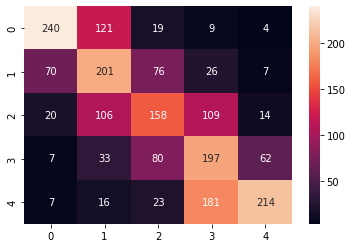

In [54]:
# fit the model
####SOURCE:::  https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
model_m4.fit(tensor_train, y_train, epochs=5, verbose=1,validation_data=(tensor_val, y_val))
# evaluate the model
accuracy = model_m4.evaluate(tensor_test, multi_test.label, verbose=1)
print("Accuracy for multi test data",accuracy[1])
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model_m4.predict(tensor_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(multi_test.label, y_pred_bool))

cf_matrix=confusion_matrix(multi_test.label, y_pred_bool)
sns.heatmap(cf_matrix, annot=True,fmt="d")

# **My Report**
##Preprocessing:
I did preprocessing to both train and test data by performing first lower casing then tokenized each word and removed stop words from tokenized list, I also got rid of punctuations since they dont hold a meaning. Finally I did stemming using Porter Stemmer since it helps us to have minimum stem words such as converting Connects, connecting to connect.

Our training data has 18000 instances and test data has 2000.
##Dataset preparation: 
I used pandas replace function to map certain label values to new ones. 
Ended up with binary data which has 0-1 as labels and multi-data which has 0,1,2,3,4 as labels. The class distributions for each dataset as follows: 

BINARY TRAIN:
*  0   ->  7227
*  1   ->  7180

BINARY TEST:
* 0 -> 820
* 1 -> 772

MULTI TRAIN:
* 3 -> 3621
* 1 -> 3620
* 0 -> 3607
* 2 -> 3593
* 4 -> 3559

MULTI TEST:
* 4 -> 441
* 2 -> 407
* 0 -> 393
* 1 -> 380
* 3 -> 370







##Non-neural models: 
###Naive bayes:

For term weighting we used Tfidf vectorizer from sklearn, which is required to represent words as numeric values to show their dominancy (term frequency) in the dataset. DenseTransformer will convert this into a matrix. After the pipeline I created a gridsearch parameter space which consists; ngram numbers and min_df for tfidf vectorizer. N-gram range options are unigrams, unigrams and bigrams, unigrams and bigrams and trigrams. 

We are also given a condition “For a term to be valid it should exist in at least N documents.” therefore I try min_df as 100,500,1000. Since we used 5 folds in grid seach we have 5 splits in total each having 9 (3x3) possibilities in NB case. I report the max and min of the combinations. After finding the best parameters I fit the data into model by using those and predict the test data. 
Lastly I report accuracy and f1 score as 0.87 for binary and 0.49 , 0.47 for multi-class.Best paramters for both binary and multi-class data are n_gram=(1,2) and min_df=100.
The confusion matrix also proves that results are good by looking at the diagonal. Same steps are applied in both binary and multi-class data.

###Logistic Regression: 

For term weighting we used Tfidf vectorizer and Dense transformer again. Parameter space has 1 more element which is l1 ratio, which sets penalty according to the ratio i.e it can be combination of l1,l2 if given 0.5. 

In logistic regression component we have some set parameters; random_state= 22 penalty= elasticnet and solver=saga . In order to use l1_ratio in grid search we need to set penalty as elasticnet and to use elasticnet option we need to set solver as saga according to sklearn.

Rest is applied same as NB. The F1 and accuracy scores for binary data are 0.91, 0.9 and the best hyper-parameter combination is found to be l1_ratio=0.5 (combination of l1 & l2) ,min_df=100 and n_gram=(1,2).
And for multi-class f1 and acc score is 0.55 with best parameters being n_gram=(1,3), min_df=100 and l1_ratio=1.0


###Analysis:
LR performed better scores in both datasets than NB, while NB had a much smaller time complexity. This is due to lr being a discriminative model whereas NB is a generative one. In discriminative models, correlation is also taken into consideration however in NB all features are tought to be independent. However, in our dataset our features are corraleted with labels. So I assume if we were to have a bigger dataset example, LR would outperform NB more significantly.

##CNN:
After splitting the training data as train,val we have 12966 train, 1441 val for binary dataset (we have less data since we got rid of class 3). And 16200 training and 1800 for val in multi-class.

Again to represent words as numbers this time we create word embedding matrices using Word2vec and also a pre-trained matrix.  My trained from scratch model_gensim has a size of 60 since that is my padding size. Model gensim returns a number for each word, and similar words has similar numeric values(like first,second). For padding I choose this value which is close to the average of token numbers of instances in the data. The reason for not using max is that outliers may be misleading. Before padding the dataset, I use keras tokenizer and create train,val,test tensors by fitting the dataset into tokenizer and convert them to numeric values by text to sequence. 


Then , I create 2 embedding matrices ; trained from scratch matrix has the size of  [vocabulary_size(21050),60(padding)] whereas pre-trained matrix has the size [vocabulary_size(21050),50(glove-twitter-50)]. I implement the for loops using try-catch blocks becuase not every word in my tokenizer exist in model_gensim or glove-twitter-50. Not existing words remain as 0. I use this embedding matrices later for the embedding layer weights.

To create a CNN model I used keras sequantial which consists an  embedding layer , conv1d, maxpooling and dense layers. I trained all models for 5 epochs since it is more than enough because training accuracy reaches very high at 5th epoch, and default batch size 32 is used.  
##BINARY dataset: 
In all models for binary training, I use binary_crossentropy as loss and set my last layer as  output size=1 and act function=sigmoid (this can also be softmax with 2 classes). After predicting the test data, I set a threshold of 0.5 and map (x>0.5) to 1 and (x< 0.5) to 0 so that I can have a confusion matrix and calculate F1 scores etc. To calculate F1, precision, recall and accuracy I use sklearn's classification_report for convenience.

###RANDOM EMBEDDING:
-> conv1d 128, conv1d 32 with 5 kernel size ,dense 20 with random embedding weights :
accuracy is 0.88

-> conv1d 256, conv1d 128, conv1d 64, with 5 kernel size ,dense 20 with random embedding weights :
accuracy is 0.88

###PRETRAINED EMBEDDING: 
-> conv1d 128, conv1d 32 with 5 kernel size with pretrained glove embedding weights :
accuracy is 0.88

-> conv1d 256, conv1d 128, conv1d 32 with 3 kernel size with pretrained glove embedding weights :
accuracy is 0.89

###TRAINED EMBEDDING:
-> conv1d 128, conv1d 32 with 5 kernel size  dense 20 with trained embedding weights :
accuracy is 0.90

-> conv1d 256, conv1d 128, conv1d 64 ,conv1d 32 with 7 kernel size dense 400 - 250-20 with trained embedding weights (trained for 8 epochs) :
accuracy is 0.89

###Analysis:

For the first models of each embedding combination we can see that all of them have the similar accuracy scores, best is obtained with trained weights and random weights performed the lowest. I think this is due to binary classification being an easy task and having random weights or pre-trained weights does not affect model performance as expected.However since pre-trained and trained weights has been trained with some corpus and have ready weights we expect to see higher accuracy. And trained weights has higher accuracy than pre-trained this may be due to using glove-twitter weights the content of the corpus may not be as suitable as the trained embedding. 

In random embedding setting, adding 2 more conv layer did not change the accuracy, however adding 1 more conv layer and decreasing kernel size increased accuracy by 1% in pre-trained setting. I also tried to see if training the model more epochs would help, we can see in trained embedding setting in total there are 3 dense layers and 4 conv layers w,th kernel size 7 I tried training for 8 epochs but since model achieves enough training accuracy at epoch 5 it did not change the result visibly.


##MULTI :
In all models for multi training, I use sparse_crossentropy as loss and set my last layer as  output size=5 (there are 5 classes) and act function=softmax.After predicting the test data, I use np.argmax to obtain the index number of the highest probability and map it as the labels of test data, so that I can have a confusion matrix and calculate F1 scores etc. To calculate F1, precision, recall and accuracy I use sklearn's classification_report for convenience. 

###RANDOM EMBEDDING:

-> conv1d 128, conv1d 64 with 5 kernel size ,dense with 20 output_size  with random embedding weights :
accuracy is 0.52

-> conv1d 128, conv1d 64 with 5 kernel size ,dense with 400 output_size  with random embedding weights :
accuracy is 0.51



###PRE-TRAINED EMBEDDING:

-> conv1d 128, conv1d 64 with 3 kernel size ,dense with 20 output_size  with pretrained embedding weights :
accuracy is 0.5

-> conv1d 128, conv1d 64 with 9 kernel size ,dense with 20 output_size  with pretrained embedding weights :
accuracy is 0.49 f1 is 0.5




###TRAINED EMBEDDING:

->  conv1d 256, conv1d 128, conv1d 64 ,with 7 kernel size ,dense with 20 output_size  with trained embedding weights :
accuracy is 0.54


->  conv1d 64 with 3 kernel size ,dense with 20 output_size  with trained embedding weights :
accuracy is 0.51



###Analysis:
In each embedding option I tried different hyper-parameter tuning cases. The one with the significant difference is number of conv layers. As it is seen in Trained from scratch embedding examples, I tried 3 vs 1 conv layer with differen kernel sizes and accuracy only decreased by 3% in 1 layered model. In pre-trained embedding we can observe very significant decrease in accuracy when we change kernel size from 3 to 9 , this of course gives model more parameters to tune but does not necessarily improves performance. And for the random embeddings I changed the units parameter of the dense layer, having more parameters did not increase the accuracy instead lowered it by 1%. Having a more complex model may result in overfitting the test data so we need to optimize our parameter number. Overall we observed the best metrics in Trained setting which is obviously expected since we trained the embedding with our domain. In multiclass, we also observe that model is very good at predicting class 0 and 4 which are the two very negative and positive classes and other classes the F1 score is generally around 40% whereas we see 0 and 4 labels around 60%.



##SOURCES I used for word embedding and cnn layers:
 https://ml2021.medium.com/multi-class-text-classification-using-cnn-and-word2vec-b17daff45260

 https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

 https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

 https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9

 https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model  




In [57]:
%%shell
jupyter nbconvert --to html /content/445_Project_1_Notebook.ipynb

[NbConvertApp] Converting notebook /content/445_Project_1_Notebook.ipynb to html
[NbConvertApp] Writing 1365617 bytes to /content/445_Project_1_Notebook.html
